## **SHAPLEY VALUE / CIFAR10**
PROCESSAMENTO DE IMAGENS DIGITAIS (2024) / ARTHUR FRANCISCO RAMOS, JOÃO PEDRO VIEIRA RODRIGUES

### IMPORTAÇÃO DE BIBLIOTECAS

In [40]:
import numpy as np
import shap

from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.models import Sequential

### PARAMÊTROS / VARIÁVEIS GLOBAIS

Nessa etapa foram definidas variáveis e parâmetros como tamanho de imagens, tamanho do lote de processamento, número de épocas, número de classes e começo e fim das imagens de testes que foram consideradas na geração dos valores de _Shapley_.

In [24]:
NUM_CHANNELS = 3
IMG_SIZE = 32
BATCH_SIZE = 64

NUM_EPOCHS = 20
NUM_CLASSES = 10

IMAGE_START = 5
IMAGE_END = 10
NUM_COMPARE = 5

### LEITURA E TRATAMENTO DO DATASET / RÓTULOS

Nessa fase foi realizada a leitura e normalização do dataset, definindo os pixels da imagem em um intervalo de [0, 1], nessa etapa também foram definidas as classes e os rótulos de cada classe.

In [4]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()
train_images, test_images = train_images.reshape(-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS), test_images.reshape(-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS)

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

classes =  np.unique(train_labels)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
mapping = dict(zip(classes, class_names))

### ARQUITETURA DO MODELO

Nessa etapa foi definida uma estrutura _CNN_ para o treinamento do modelo, qualquer modelo poderia ter sido utilizado, optamos pelo uso da CNN pela maior "facilidade de implementação" e pelo treinamento ter atingido uma boa acurácia.

Modelos pré-treinados também foram avaliados, mas não estavam atingindo a acurácia desejada ou não tinham tanta flexibilidade em configuração, interferindo na implementação do pacote _SHAP_.

In [6]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (IMG_SIZE, IMG_SIZE, NUM_CHANNELS)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(NUM_CLASSES, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_7 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_8 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                      

### CONFIGURAÇÃO E TREINAMENTO DO MODELO

O modelo foi configurado com um optimizer baseado em _Adam_ e uma função de perda definida pela _sparse_categorical_crossentropy_, em relação à métrica de avaliação, foi utilizada a acurácia para validar o desempenho da arquitetura na base de validação.

In [8]:
model.compile(
    optimizer = 'adam', 
    loss = "sparse_categorical_crossentropy", 
    metrics = ['accuracy']
)

history = model.fit(
    train_images, train_labels, 
    batch_size = BATCH_SIZE, 
    epochs = NUM_EPOCHS,
    validation_data = (test_images, test_labels)
)

Epoch 1/20
782/782 [==============================] - 10s 10ms/step - loss: 1.0331 - accuracy: 0.6344 - val_loss: 0.9045 - val_accuracy: 0.6882
Epoch 2/20
782/782 [==============================] - 7s 9ms/step - loss: 0.6710 - accuracy: 0.7663 - val_loss: 0.8176 - val_accuracy: 0.7146
Epoch 3/20
782/782 [==============================] - 7s 9ms/step - loss: 0.5216 - accuracy: 0.8187 - val_loss: 0.6820 - val_accuracy: 0.7711
Epoch 4/20
782/782 [==============================] - 7s 9ms/step - loss: 0.4024 - accuracy: 0.8600 - val_loss: 0.6810 - val_accuracy: 0.7763
Epoch 5/20
782/782 [==============================] - 6s 8ms/step - loss: 0.3046 - accuracy: 0.8938 - val_loss: 0.6310 - val_accuracy: 0.8003
Epoch 6/20
782/782 [==============================] - 7s 9ms/step - loss: 0.2232 - accuracy: 0.9231 - val_loss: 0.6618 - val_accuracy: 0.8020
Epoch 7/20
782/782 [==============================] - 7s 9ms/step - loss: 0.1612 - accuracy: 0.9441 - val_loss: 0.7520 - val_accuracy: 0.7961
Epoc

### ESTATÍSTICAS DE TREINAMENTO

Nessa etapa foi possível verificar que o modelo apresentou uma acurácia de 79%, suficiente para demonstrar as funcionalidades dos valores de Shapley, tanto para predições corretas quanto para predições incorretas.

In [9]:
Y_test_preds = model.predict(test_images)
Y_test_preds = np.argmax(Y_test_preds, axis = 1)

print(f"Test Accuracy: {accuracy_score(test_labels, Y_test_preds)}")

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, Y_test_preds))

print("\nClassification Report:")
print(classification_report(test_labels, Y_test_preds, target_names = class_names))

313/313 [==============================] - 1s 2ms/step
Test Accuracy: 0.7928

Confusion Matrix:
[[768   8  23  46  15  12   7  15  75  31]
 [  5 878   0  12   4  11   3   3  25  59]
 [ 50   4 615 108  64  65  40  38  11   5]
 [ 10   4  33 741  28 115  28  25   9   7]
 [  9   1  33  64 757  49  29  49   8   1]
 [  3   1  13 171  26 744   7  30   1   4]
 [  3   1  23  84  26  22 823   7   9   2]
 [  3   1   6  61  27  50   1 845   5   1]
 [ 25  13   6  23   2   9   3   7 898  14]
 [ 14  49   2  17   4  12   4  11  28 859]]

Classification Report:
              precision    recall  f1-score   support

    airplane       0.86      0.77      0.81      1000
  automobile       0.91      0.88      0.90      1000
        bird       0.82      0.61      0.70      1000
         cat       0.56      0.74      0.64      1000
        deer       0.79      0.76      0.78      1000
         dog       0.68      0.74      0.71      1000
        frog       0.87      0.82      0.85      1000
       horse    

### GERAÇÃO DOS VALORES DE SHAPLEY

Essa fase consiste na geração dos valores de _Shapley_, onde cada função pode ser explicada abaixo:

- _shap.maskers.Image_ = retorna uma máscara responsável por perturbar partes da imagem, essa máscara será usada pela função seguinte para mensurar a importância dos pixels na predição do modelo.
- _shap.PermutationExplainer_ = esse _Explainer_ utiliza um método semelhante à aproximação de _Monte-Carlo_, a cada iteração são realizadas permutações entre as _features_ por outros valores do conjunto de dados de forma a aproximar os resultados do valor de _Shapley_ real.
- _explainer_ = função responsável pelo cálculo dos valores de _Shapley_, o parâmetro _outputs_ define a quantidade de itens que serão usados na comparação, enquanto o _max_evals_ define a quantidade de vezes em que o modelo será avaliado com permutações.

In [39]:
masker = shap.maskers.Image("blur(32,32)", (IMG_SIZE, IMG_SIZE, NUM_CHANNELS))
explainer = shap.PermutationExplainer(model, masker, output_names = class_names)

shap_values = explainer(test_images[IMAGE_START:IMAGE_END], max_evals = 6145, outputs = shap.Explanation.argsort.flip[:NUM_COMPARE])

PermutationExplainer explainer: 6it [00:33,  8.41s/it]                       


### IMAGENS COM OS VALORES DE SHAPLEY DESTACADOS

Etapa demonstrativa, consiste em mostrar a mesma imagem para _x_ classes distintas e mostrar quais foram os _pixels/features_ mais relevantes e irrelevantes no processo de decisão, os pontos vermelhos representam pontos que colaboram para que a imagem seja classificada em um determinado rótulo, e os azuis representam os que interferem de forma negativa na predição.

Actual Labels: ['frog', 'automobile', 'frog', 'cat', 'automobile']
1/1 [==============================] - 0s 12ms/step
Predicted Labels: ['frog', 'cat', 'frog', 'cat', 'automobile']
Probabilities: [0.9997602  0.63228005 0.4981087  0.9999999  0.9977374 ]
1/1 [==============================] - 0s 13ms/step


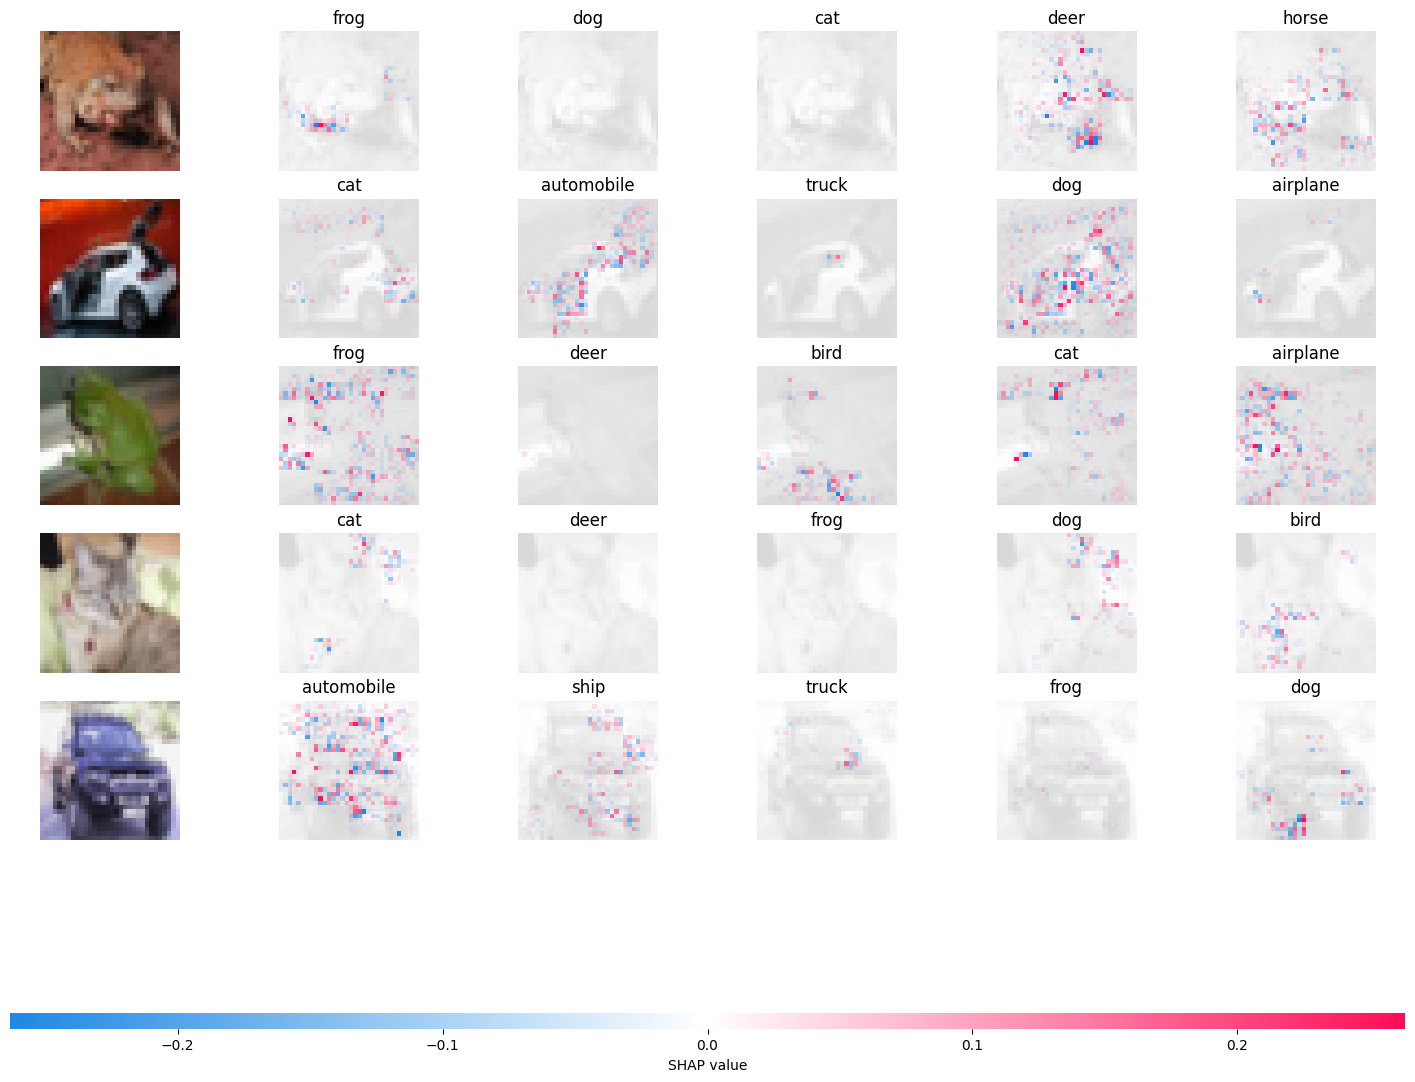

In [23]:
print(f"Actual Labels: {[mapping[i[0]] for i in test_labels[IMAGE_START:IMAGE_END]]}")

probs = model.predict(test_images[IMAGE_START:IMAGE_END])

print(f"Predicted Labels: {[mapping[i] for i in np.argmax(probs, axis = 1)]}")
print(f"Probabilities: {np.max(probs, axis = 1)}")

Y_preds = model.predict(test_images[IMAGE_START:IMAGE_END])

Y_preds = Y_preds.argsort()[:, ::-1]
Y_labels = [[class_names[val] for val in row] for row in Y_preds]
Y_labels = np.array(Y_labels)

shap.image_plot(shap_values[:, :, :, :, :NUM_COMPARE], labels = Y_labels[:, :NUM_COMPARE])

### INTERPRETAÇÃO E RESULTADOS

Em relação aos resultados, é possível perceber que muitos pixels de fundo estão sendo considerados nas imagens, o que pode acarretar interpretações errôneas por conta de ruídos.

Outro resultado que também pode ser avaliado é que devido a baixa resolução das imagens (32x32), se torna mais complicado inferir alguma interpretação de pixels mais e menos relevantes para a predição.

Entretanto, a aplicação supre a ideia de demonstrar os valores de _Shapley_ em um contexto de imagens, mostrando de forma intuititiva como os pixels podem ter sua contribuição mensurada, auxiliando em tarefas pré-treinamento e pós-treinamento.

Um detalhe importante a ressaltar é que a escolha da base de dados e a resolução aplicada se resume em dois pontos principais, um treinamento do modelo mais fácil, permitindo o foco na implementação dos valores de _Shapley_ e reduzir o uso computacional das funções utilizadas para o cálculos dos mesmos.

*OBS:* durante o desenvolvimento, uma tentativa foi realizada com imagens de tamanho 112x112, porém estavam causando estouro de memória com uma tentativa de alocar 42 GB, sendo necessário então adaptar a implementação para bases de dados com menos resoluções.